<a href="https://colab.research.google.com/github/JCaballerot/Machine_learning_program/blob/main/Supervised_models/KNN/Salary_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [213]:
#!pip3 install category_encoders

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import category_encoders as ce
from sklearn.model_selection import train_test_split


### 1. Leyendo los datos

In [215]:

pddf = pd.read_csv('Salary Data.csv')
pddf = pddf.loc[pddf.Salary > 100]
pddf.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


### 2. Muestreo

In [216]:
# Muestreo
train, test = train_test_split(pddf,
                               train_size = 0.7,
                               random_state = 123)


### 3. Codificación de variables categóricas

In [217]:

encoder = ce.TargetEncoder(cols=['Gender', 'Education Level', 'Job Title'])
encoder = encoder.fit(train, train['Salary'])



In [218]:

train_encoded = encoder.transform(train)
test_encoded = encoder.transform(test)


In [219]:
test_encoded.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
150,29.0,96083.480702,75865.413722,99329.501916,3.0,45000.0
356,45.0,96083.480702,146464.811144,106871.793690,16.0,160000.0
54,29.0,96083.480702,75865.413722,99329.501916,3.0,50000.0
102,49.0,96083.480702,122604.576641,99329.501916,19.0,150000.0
322,39.0,96083.480702,75865.413722,104377.307023,12.0,130000.0


In [220]:
len(test_encoded)

112

### 4. Tratamiento de outliers

In [221]:
# Calcular la media y la desviación estándar de las variables
mean = train_encoded.mean()
std  = train_encoded.std()

In [222]:
# Definir el criterio para detectar outliers (por ejemplo, considerando valores a más de 3 desviaciones estándar)
threshold = 3
outlier_criteria = (np.abs(train_encoded - mean) > threshold * std)


In [223]:
# Capear los outliers a un valor máximo o mínimo
train_treat = train_encoded.clip(lower = train_encoded - threshold * std, upper = train_encoded + threshold * std)
test_treat  =  test_encoded.clip(lower = test_encoded - threshold * std, upper = test_encoded + threshold * std)


In [224]:

def cut_limits(x, lower_limit, upper_limit):
  if x > upper_limit:
    return upper_limit
  elif x < lower_limit:
    return lower_limit
  else:
    return x


In [225]:

univ = train_encoded.describe(percentiles = [0.02, 0.98]).transpose()

train_treat = train_encoded.copy()
test_treat  =  test_encoded.copy()

for col in univ.index:
  print('tratamiento', col)
  q3 = univ.loc[univ.index == col]['98%'][0]
  q1 = univ.loc[univ.index == col]['2%'][0]
#  upper_limit = q3 + 1.5*(q3 - q1)
#  lower_limit = q1 - 1.5*(q3 - q1)
  upper_limit = q3
  lower_limit = q1
  train_treat[col] = train_treat[col].apply(lambda x: cut_limits(x, lower_limit, upper_limit))
  test_treat[col] = test_treat[col].apply(lambda x: cut_limits(x, lower_limit, upper_limit))


tratamiento Age
tratamiento Gender
tratamiento Education Level
tratamiento Job Title
tratamiento Years of Experience
tratamiento Salary


In [226]:
test_treat.Salary.describe()

count       112.000000
mean     102500.000000
std       50542.106253
min       35000.000000
25%       55000.000000
50%       95000.000000
75%      150000.000000
max      180000.000000
Name: Salary, dtype: float64

In [227]:
test_treat.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
150,29.0,96083.480702,75865.413722,99329.501916,3.0,45000.0
356,45.0,96083.480702,146464.811144,106871.793690,16.0,160000.0
54,29.0,96083.480702,75865.413722,99329.501916,3.0,50000.0
102,49.0,96083.480702,122604.576641,99329.501916,19.0,150000.0
322,39.0,96083.480702,75865.413722,104377.307023,12.0,130000.0


<Axes: xlabel='Salary'>

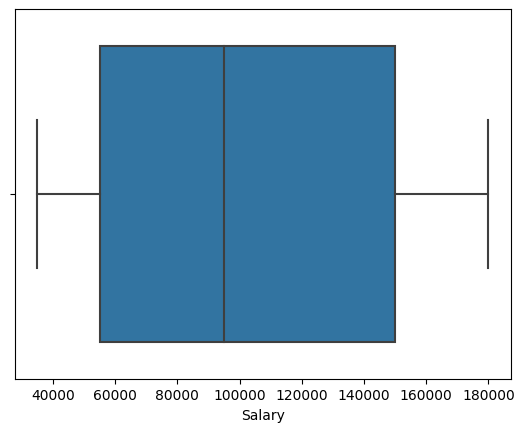

In [228]:
sns.boxplot(data = test_treat, x = 'Salary')

### 5. Estandarización de datos

In [229]:
X_train = train_treat[['Age',	'Gender',	'Education Level',	'Job Title',	'Years of Experience']]
X_test  =  test_treat[['Age',	'Gender',	'Education Level',	'Job Title',	'Years of Experience']]

y_train = train_treat.Salary
y_test  =  test_treat.Salary


In [230]:
len(X_test)

112

In [231]:
# Estandarizar las variables en el DataFrame

X_train_scaled = (X_train - X_train.mean())/X_train.std()
X_test_scaled  = ( X_test - X_train.mean())/X_train.std()


In [232]:
X_test_scaled.head()

,Age,Gender,Education Level,Job Title,Years of Experience
150,-1.200796,-1.081896,-0.791489,-0.031426,-1.080969
356,1.127426,-1.081896,1.758727,1.032211,0.972630
54,-1.200796,-1.081896,-0.791489,-0.031426,-1.080969
102,1.709481,-1.081896,0.896840,-0.031426,1.446538
322,0.254343,-1.081896,-0.791489,0.680431,0.340753


### 6. Tratamiento de missings

In [233]:
# Calcular la cantidad de valores faltantes por columna
missing_values = X_train_scaled.isnull().sum()
print(missing_values)

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
dtype: int64


In [234]:
X_train_f = X_train_scaled.fillna(X_train_scaled.median())
X_test_f  =  X_test_scaled.fillna(X_train_scaled.median())


### 7. KNN

In [235]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import *

# Crear un objeto KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors = 30)
knn.fit(X_train_f, y_train)


KNeighborsRegressor(n_neighbors=30)

In [236]:
# Realizar predicciones en el conjunto de prueba
y_train_pred = knn.predict(X_train_f)
y_test_pred = knn.predict(X_test_f)


### 8. Performance

In [237]:
y_test.describe(percentiles = [0.01, 0.99])

count       112.000000
mean     102500.000000
std       50542.106253
min       35000.000000
1%        35000.000000
50%       95000.000000
99%      180000.000000
max      180000.000000
Name: Salary, dtype: float64

Text(0, 0.5, 'Real')

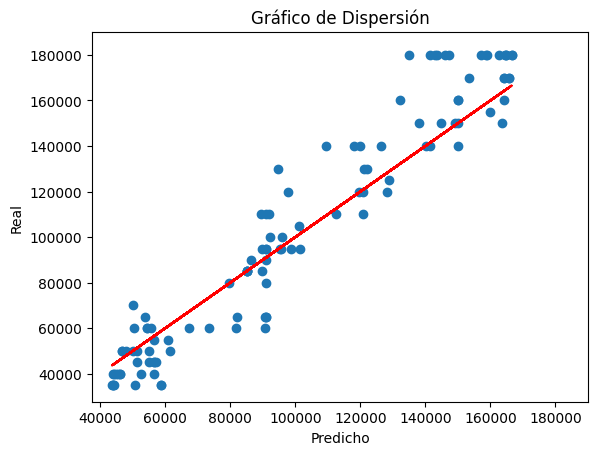

In [238]:
# Crear el gráfico de dispersión
plt.scatter(y_test_pred, y_test)
plt.plot(y_test_pred, y_test_pred, color='red')

# Establecer el límite del eje Y como el máximo valor en el eje X
plt.xlim(plt.xlim()[0], 190000)
plt.ylim(plt.ylim()[0], 190000)

# Personalizar el gráfico
plt.title('Gráfico de Dispersión')
plt.xlabel('Predicho')
plt.ylabel('Real')

In [239]:
# Calcular las métricas de regresión
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
r2 = r2_score(y_test, y_test_pred)



In [240]:
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

MAE: 11525.29761904762
MSE: 235528025.7936508
RMSE: 15346.922355757548
R^2: 0.9069682987519347


In [241]:
len(X_test_f)

112

<Axes: xlabel='K', ylabel='train'>

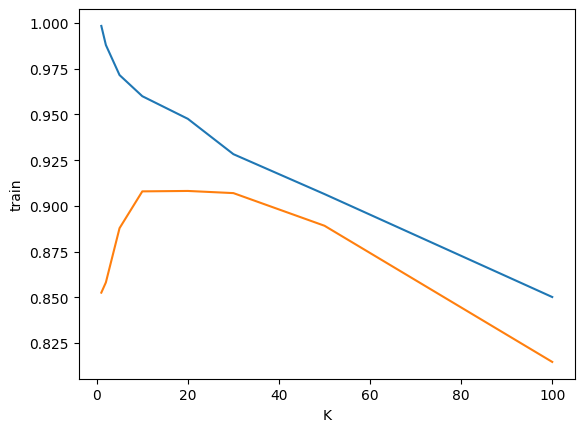

In [246]:

grid = [1, 2, 5, 10, 20, 30, 50, 100]
list_train = []
list_test = []

for k in grid:
  knn = KNeighborsRegressor(n_neighbors = k)
  knn.fit(X_train_f, y_train)
  # Realizar predicciones en el conjunto de prueba
  y_train_pred = knn.predict(X_train_f)
  y_test_pred = knn.predict(X_test_f)

  list_train.append(r2_score(y_train, y_train_pred))
  list_test.append(r2_score(y_test, y_test_pred))

res = pd.DataFrame({'K':grid,
                    'train':list_train,
                    'test':list_test})

import seaborn as sns

sns.lineplot(data=res, x = 'K', y = 'train')
sns.lineplot(data=res, x = 'K', y = 'test')

In [245]:
res

,K,train,test
0,2,0.988013,0.858094
1,5,0.971571,0.887780
2,10,0.959995,0.907920
3,20,0.947613,0.908147
4,30,0.928274,0.906968
5,50,0.906434,0.889100
6,100,0.850097,0.814581
